In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	
==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	macaw	
predicted class 3: 	flamingo	
predicted class 4: 	axolotl, mud puppy, Ambystoma mexicanum	
predicted class 5: 	eft	


In [2]:
local SpatialDeconvolution, parent = torch.class('SpatialDeconvolution', 'cudnn.SpatialConvolution')


function SpatialDeconvolution:__init( convLayer, reconstruction_size, neuron_num, normal_deconv )
    assert( torch.typename(convLayer) == 'cudnn.SpatialConvolution', 'Input should be cudnn.SpatialConvolution()')
    parent.__init(self, convLayer.nOutputPlane, convLayer.nInputPlane, convLayer.kW, convLayer.kH, convLayer.dW, 
                  convLayer.dH, convLayer.padW, convLayer.padH, convLayer.groups)
    self:reset() 
    
    self.normal_deconv = normal_deconv or false
    self.neuron_num = neuron_num or 0
    if self.neuron_num == true then
        self.neuron_num = 0 
        self.normal_deconv = true
    end
    
    if self.neuron_num == false then
        self.neuron_num = 0 
        self.normal_deconv = false
    end 
    
    
    self.reconstruction_size = reconstruction_size
    self.weight=convLayer.weight:clone()
        
    flip = function(m,d) return m:index(d,torch.range(m:size(d),1,-1):long())end
    self.weight = flip(flip(self.weight,4),3)
    self.gradWeight=convLayer.gradWeight    
end



function SpatialDeconvolution:updateOutput(input)
    local deconv_output = self.nInputPlane
    local total_deconv = self.nInputPlane
    if torch.type(self.neuron_num)~='torch.IntTensor' and self.neuron_num ~= 0 then
        total_deconv = 1
        deconv_output = 1
    end    
    
    if torch.type(self.neuron_num) == 'torch.IntTensor' then
        total_deconv = self.neuron_num:size(1)
        deconv_output = 1
    end
    
    if normal_deconv == true then
        deconv_output = 1
    end
            
    local deconv_fm = torch.CudaTensor( deconv_output, self.nOutputPlane, self.reconstruction_size, 
                                         self.reconstruction_size):zero():cuda()
    local deconv = cudnn.SpatialConvolution(1, 1, self.kW, self.kH, 1, 1, 
                                            math.floor(self.kW/2), math.floor(self.kH/2), self.group):cuda()
    
    local conv_scat_fm = torch.zeros(total_deconv, self.reconstruction_size, self.reconstruction_size):cuda()
    local stride_size = self.dH
    local padding_size = (self.reconstruction_size - (input:size(2) * stride_size))/2
    
    local n=input:size(2)
    local x=stride_size
    
   
    --timer = torch.Timer()
    if self.reconstruction_size ~= input:size(2) then
        -- Scatter     contributed by TingFan
        local idx=torch.LongTensor(n*n,1):cuda()
        local counter=1;
        for i=x,n*x,x do
            for j=x,n*x,x do
                idx[counter]=(i+math.floor(padding_size))*(n*x+padding_size*2) + j + math.floor(padding_size)
                counter=counter+1;
            end
        end

        local total_size = (n*x+padding_size*2)*(n*x+padding_size*2)
        for i=1,total_deconv do
            local fm_index = i
            
            if torch.type(self.neuron_num) ~= 'torch.IntTensor' then
                if self.neuron_num ~= 0 then
                     fm_index = self.neuron_num
                end
            else
                fm_index = self.neuron_num[i]
            end
                
            local m=torch.zeros(n*x+padding_size*2,n*x+padding_size*2):cuda()
            local output = input[fm_index]:view(n*n,1)
            m:view(total_size,1):scatter(1,idx,output)
            conv_scat_fm[i] = m
        end      
    else
        if torch.type(self.neuron_num) ~= 'torch.IntTensor' and self.neuron_num ~= 0 then
            conv_scat_fm[{{1},{},{}}] = input[{{self.neuron_num},{},{}}]
        elseif torch.type(self.nuuron_num) == 'torch.IntTensor' then
            for i=1,self.nuuron_num:size(1) do
                conv_scat_fm[i] = input[{{self.neuron_num[i]},{},{}}]
            end
        else
            conv_scat_fm = input:cuda()
        end
    end
        
    --print('==> Scatter Time elapsed: ' .. timer:time().real .. ' seconds')
    --timer2 = torch.Timer()
    -- Deconv
    if self.normal_deconv == false then
        if torch.type(self.neuron_num) ~= 'torch.IntTensor' then
            for i=1, total_deconv do
                for j=1, self.nOutputPlane do
                    local weight_index = i
                    if self.neuron_num ~= 0 then
                        weight_index = self.neuron_num
                    end

                    local fm = conv_scat_fm[i]
                    deconv.weight = self.weight[weight_index][j]
                    local deconv_result = deconv:forward(fm:view(1, self.reconstruction_size, self.reconstruction_size)):cuda()
                    -- BGR to RGB
                    if self.nOutputPlane==3 then
                        deconv_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
                    else
                        deconv_fm[{ {i}, {j}, {}, {} }] = deconv_result
                    end            
                end
            end      
        else
            for i=1, total_deconv do
                for j=1, self.nOutputPlane do
                    local weight_index = i
                    weight_index = self.neuron_num[i]
                    local fm = conv_scat_fm[i]
                    deconv.weight = self.weight[weight_index][j]
                    local deconv_result = deconv:forward(fm:view(1, self.reconstruction_size, self.reconstruction_size)):cuda()
                    -- BGR to RGB
                    if self.nOutputPlane==3 then
                        deconv_fm[{ {1}, {3-(j-1)}, {}, {} }] = deconv_fm[{ {1}, {3-(j-1)}, {}, {} }] + deconv_result
                    else
                        deconv_fm[{ {1}, {j}, {}, {} }] = deconv_fm[{ {1}, {j}, {}, {} }] + deconv_result
                    end                       
                end
            end
        end
    else
        local deconv_normal = cudnn.SpatialConvolution( self.nInputPlane, self.nOutputPlane, self.kW, self.kH, 1, 1, 
                                                        math.floor(self.kW/2), math.floor(self.kH/2), self.group):cuda()         
        deconv_normal.weight = torch.CudaTensor( self.nOutputPlane, self.nInputPlane, self.kW, self.kH )
        
        timer2 = torch.Timer()
        deconv_normal.weight = self.weight:transpose(1, 2):contiguous()          
        deconv_fm = deconv_normal:forward(conv_scat_fm):cuda()
        -- BGR to RGB
        if self.nOutputPlane==3 then
          local temp = deconv_fm:clone()
          deconv_fm[{1,{},{}}] = temp[{3,{},{}}]
          deconv_fm[{3,{},{}}] = temp[{1,{},{}}]   
        end
    end   
    
    --print('==> Deconv Time elapsed: ' .. timer2:time().real .. ' seconds')
    cutorch.synchronize()
    if deconv_fm:dim() == 4 and deconv_output==1 then
        return deconv_fm[1] 
    end    
    
    return deconv_fm
end 



==> Time elapsed: 0.2304949760437 seconds	


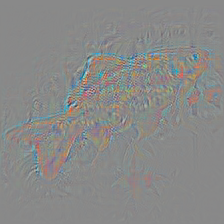

In [3]:
-- set deconvNet
deconvNet = nn.Sequential()

conv5_fm = net:get(1):get(13).output
deconvNet:add(SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 153 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

In [15]:
-- conv1_fm = net:get(1):get(1).output
-- deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), false )
-- vis_c1 = deconv1:forward(conv1_fm)
-- itorch.image(vis_c1)

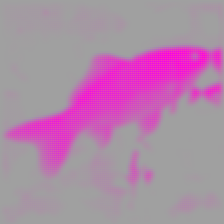

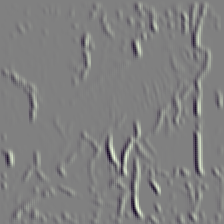

In [4]:
conv1_fm = net:get(1):get(1).output
deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), 47 )
vis_1 = deconv1:forward(conv1_fm)

deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), 94 )
vis_2 = deconv1:forward(conv1_fm)

itorch.image(vis_1)
itorch.image(vis_2)

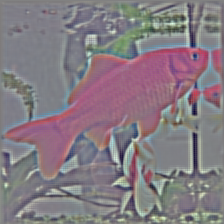

In [5]:
conv1_fm = net:get(1):get(1).output
deconv_idx = torch.IntTensor(96)
--deconv_idx[1] = 47
--deconv_idx[2] = 94

for i=1,96 do
   deconv_idx[i]=i 
end
    
deconv1 = SpatialDeconvolution( net:get(1):get(1), I:size(2), deconv_idx  )
vis_n = deconv1:forward(conv1_fm)

itorch.image(vis_n)


 256
  26
  26
[torch.LongStorage of size 3]



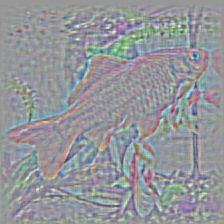

In [6]:
conv2_fm = net:get(1):get(5).output
print(conv2_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end

deconv2 = nn.Sequential()
deconv2:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), deconv_idx ))
deconv2:add(unpooling_layers[1])
deconv2:add(cudnn.ReLU(true))
deconv2:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c2 = deconv2:forward(conv2_fm)
itorch.image(vis_c2)


 384
  13
  13
[torch.LongStorage of size 3]



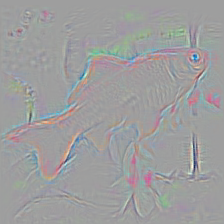

In [9]:
conv3_fm = net:get(1):get(9).output
print(conv3_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end

deconv3 = nn.Sequential()

deconv3:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), deconv_idx ))
deconv3:add(unpooling_layers[2])
deconv3:add(cudnn.ReLU(true))
deconv3:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv3:add(unpooling_layers[1])
deconv3:add(cudnn.ReLU(true))
deconv3:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c3 = deconv3:forward(conv3_fm)
itorch.image(vis_c3)


 384
  13
  13
[torch.LongStorage of size 3]



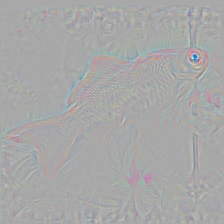

In [13]:
conv4_fm = net:get(1):get(11).output
print(conv4_fm:size() )

deconv_idx = torch.IntTensor(384)
for i=1,384 do
   deconv_idx[i]=i 
end


deconv4 = nn.Sequential()

deconv4:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), deconv_idx ))
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconv4:add(unpooling_layers[2])
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconv4:add(unpooling_layers[1])
deconv4:add(cudnn.ReLU(true))
deconv4:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))

vis_c4 = deconv4:forward(conv4_fm)
itorch.image(vis_c4)


 256
  13
  13
[torch.LongStorage of size 3]



==> Time elapsed: 10.653965950012 seconds	


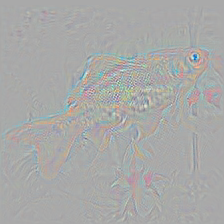

In [14]:
conv5_fm = net:get(1):get(13).output
print(conv5_fm:size() )

deconv_idx = torch.IntTensor(256)
for i=1,256 do
   deconv_idx[i]=i 
end




deconvNet = nn.Sequential()

deconvNet:add(SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), deconv_idx ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)